## Boston Crime Forecasting (June 2015- September 2018)
### Anil Abraham 2023

#### The goal of this project is to use machine learning techniques to forecast crime in Boston. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots/location.

### Brief explanation of each column:
<ul>
<li>INCIDENT_NUMBER - File number</li>
<li>OFFENSE_CODE - Code of specific crime</li>
<li>OFFENSE_CODE_GROUP - Name of crime</li>
<li>OFFENSE_DESCRIPTION - Detailed information about crime</li>
<li>DISTRICT - Boston neighbourhood</li>
<li>REPORTING_AREA - Area defined by Boston PD</li>
<li>SHOOTING - 'Y' represents a shooting occurence</li>
<li>OCCURRED_ON_DATE/YEAR/MONTH/DAY_OF_WEEK/HOUR - Date of crime</li>
<li>UCR_PART - Severity of the crime (highest is 1)</li>
<li>STREET/Lat/Long/Location - Location</li>
</ul>

### <u>Importing libraries</u>

In [174]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point, Polygon #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express as px
sns.set_style("darkgrid")
#pd.set_option('display.max_rows', None)

### <u>Data preprocessing</u>

In [175]:
df = pd.read_csv('crime.csv', encoding='latin') #Thousands are seperated by commas in the CSV.

print(f'Null values found\n{df.isna().sum()}') #Check for null values

print(f'\n\n{df.columns}') #List all feature names

Null values found
INCIDENT_NUMBER             0
OFFENSE_CODE                0
OFFENSE_CODE_GROUP          0
OFFENSE_DESCRIPTION         0
DISTRICT                 1765
REPORTING_AREA              0
SHOOTING               318054
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                   90
STREET                  10871
Lat                     19999
Long                    19999
Location                    0
dtype: int64


Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING',
       'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART',
       'STREET', 'Lat', 'Long', 'Location'],
      dtype='object')


#### Fill null values

In [176]:
df['SHOOTING'].fillna('N', inplace=True) #Null shootings should be replaced with 'N'

df.loc[df['STREET'].isna(), ('STREET')] = 'Unknown'
df.loc[df['Lat'].isna(), ('STREET')] = 'Unknown'
df.loc[df['Lat'].isna(), ('Lat')] = 42.31 #All null locations are replaced with a unique location
df.loc[df['Long'].isna(), ('Long')] = -71.17

df.loc[df['Lat'] == -1, ('STREET')] = 'Unknown'
df.loc[df['Lat'] == -1, ('Lat')] = 42.31 #All null locations are replaced with a unique location
df.loc[df['Long'] == -1, ('Long')] = -71.17

df.drop(df[df['UCR_PART'].isna()].index, inplace=True)


#### Check for duplicates

In [177]:
print(f'Before checking for duplicates\n{df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
print(f'\nAfter checking for duplicates\n{df.duplicated().sum()}')

Before checking for duplicates
23

After checking for duplicates
0


#### Check for duplicate INCIDENT_NUMBER

In [178]:
df[df['INCIDENT_NUMBER'] == 'I152030570-00']

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
318742   I152030570-00          3125     Warrant Arrests   
318743   I152030570-00           403  Aggravated Assault   
318744   I152030570-00           404  Aggravated Assault   

                                 OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA  \
318742                                WARRANT ARREST      E13            303   
318743                 ASSAULT & BATTERY D/W - OTHER      E13            303   
318744  A&B HANDS, FEET, ETC.  - MED. ATTENTION REQ.      E13            303   

       SHOOTING     OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR  \
318742        N  2016-10-29 08:25:00  2016     10    Saturday     8   
318743        N  2016-10-29 08:25:00  2016     10    Saturday     8   
318744        N  2016-10-29 08:25:00  2016     10    Saturday     8   

          UCR_PART         STREET        Lat       Long  \
318742  Part Three  W WALNUT PARK  42.317207 -71.098799   
318743    Part One  W WALNUT PARK  42.317207 -71.098799   
318744    Part One  W WALNUT PARK  42.317207 -71.098799   

                           Location  
318742  (42.31720702, -71.09879922)  
318743  (42.31720702, -71.09879922)  
318744  (42.31720702, -71.09879922)

##### Cases can have multiple crimes committed per incident, such as the one above. All the crimes belong to the same case, therefore it isn't a duplicate

#### Change categories

In [179]:
df['DAY_OF_WEEK'] = pd.Categorical(df['DAY_OF_WEEK'],  #Convert to category to save memory
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

#### Convert index to date

In [180]:
df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE']) #Convert this column to pandas datatype 'datetime'
df.index = pd.DatetimeIndex(df['OCCURRED_ON_DATE'])
df.drop(['OCCURRED_ON_DATE'], axis=1, inplace=True)

#### What are the datatypes used?

In [181]:
df.dtypes
df.isna().sum()

INCIDENT_NUMBER           0
OFFENSE_CODE              0
OFFENSE_CODE_GROUP        0
OFFENSE_DESCRIPTION       0
DISTRICT               1765
REPORTING_AREA            0
SHOOTING                  0
YEAR                      0
MONTH                     0
DAY_OF_WEEK               0
HOUR                      0
UCR_PART                  0
STREET                    0
Lat                       0
Long                      0
Location                  0
dtype: int64

#### Let's look at the first 4 records of the CSV

In [182]:
df.head(4)

INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP  \
OCCURRED_ON_DATE                                                          
2018-09-02 13:00:00      I182070945           619               Larceny   
2018-08-21 00:00:00      I182070943          1402             Vandalism   
2018-09-03 19:27:00      I182070941          3410                 Towed   
2018-09-03 21:16:00      I182070940          3114  Investigate Property   

                      OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
OCCURRED_ON_DATE                                                             
2018-09-02 13:00:00    LARCENY ALL OTHERS      D14            808        N   
2018-08-21 00:00:00             VANDALISM      C11            347        N   
2018-09-03 19:27:00   TOWED MOTOR VEHICLE       D4            151        N   
2018-09-03 21:16:00  INVESTIGATE PROPERTY       D4            272        N   

                     YEAR  MONTH DAY_OF_WEEK  HOUR    UCR_PART       STREET  \
OCCURRED_ON_DATE                                                              
2018-09-02 13:00:00  2018      9      Sunday    13    Part One   LINCOLN ST   
2018-08-21 00:00:00  2018      8     Tuesday     0    Part Two     HECLA ST   
2018-09-03 19:27:00  2018      9      Monday    19  Part Three  CAZENOVE ST   
2018-09-03 21:16:00  2018      9      Monday    21  Part Three   NEWCOMB ST   

                           Lat       Long                     Location  
OCCURRED_ON_DATE                                                        
2018-09-02 13:00:00  42.357791 -71.139371  (42.35779134, -71.13937053)  
2018-08-21 00:00:00  42.306821 -71.060300  (42.30682138, -71.06030035)  
2018-09-03 19:27:00  42.346589 -71.072429  (42.34658879, -71.07242943)  
2018-09-03 21:16:00  42.334182 -71.078664  (42.33418175, -71.07866441)

#### Crimes types grouped by UCR_PART

In [183]:
for i, g in df.groupby(['UCR_PART'], observed=True)['OFFENSE_CODE_GROUP'].unique().items():
    print(i, "\n", g, '\n')

Other 
 ['Arson' 'License Plate Related Incidents' 'Auto Theft Recovery' 'Other'
 'Manslaughter' 'Burglary - No Property Taken'] 

Part One 
 ['Larceny' 'Auto Theft' 'Robbery' 'Larceny From Motor Vehicle'
 'Residential Burglary' 'Aggravated Assault' 'Other Burglary'
 'Commercial Burglary' 'Homicide'] 

Part Three 
 ['Towed' 'Investigate Property' 'Motor Vehicle Accident Response'
 'Verbal Disputes' 'Fire Related Reports' 'Property Lost'
 'Medical Assistance' 'Assembly or Gathering Violations' 'Property Found'
 'Police Service Incidents' 'Warrant Arrests' 'Other'
 'Property Related Damage' 'Missing Person Reported' 'Investigate Person'
 'License Plate Related Incidents' 'Harbor Related Incidents'
 'Firearm Discovery' 'Landlord/Tenant Disputes' 'Missing Person Located'
 'Service' 'Search Warrants' 'License Violation' 'Explosives' 'Aircraft'
 'Prisoner Related Incidents'] 

Part Two 
 ['Vandalism' 'Other' 'Simple Assault' 'Restraining Order Violations'
 'Violations' 'Harassment' 'Ballisti

#### Every crime has been binned into a UCR_PART, indicating its severity. There exists NaN values in this column.

In [184]:
df.iloc[np.where(df['UCR_PART'].isna())]['OFFENSE_CODE_GROUP'].value_counts()

Series([], Name: OFFENSE_CODE_GROUP, dtype: int64)

#### The above 4 crimes do not have a severity rating. Categorise it as 'other'

In [185]:
df.loc[df['UCR_PART'].isna(), ('UCR_PART')] = 'Other'

### <u>Exploratory Data Analysis</u>

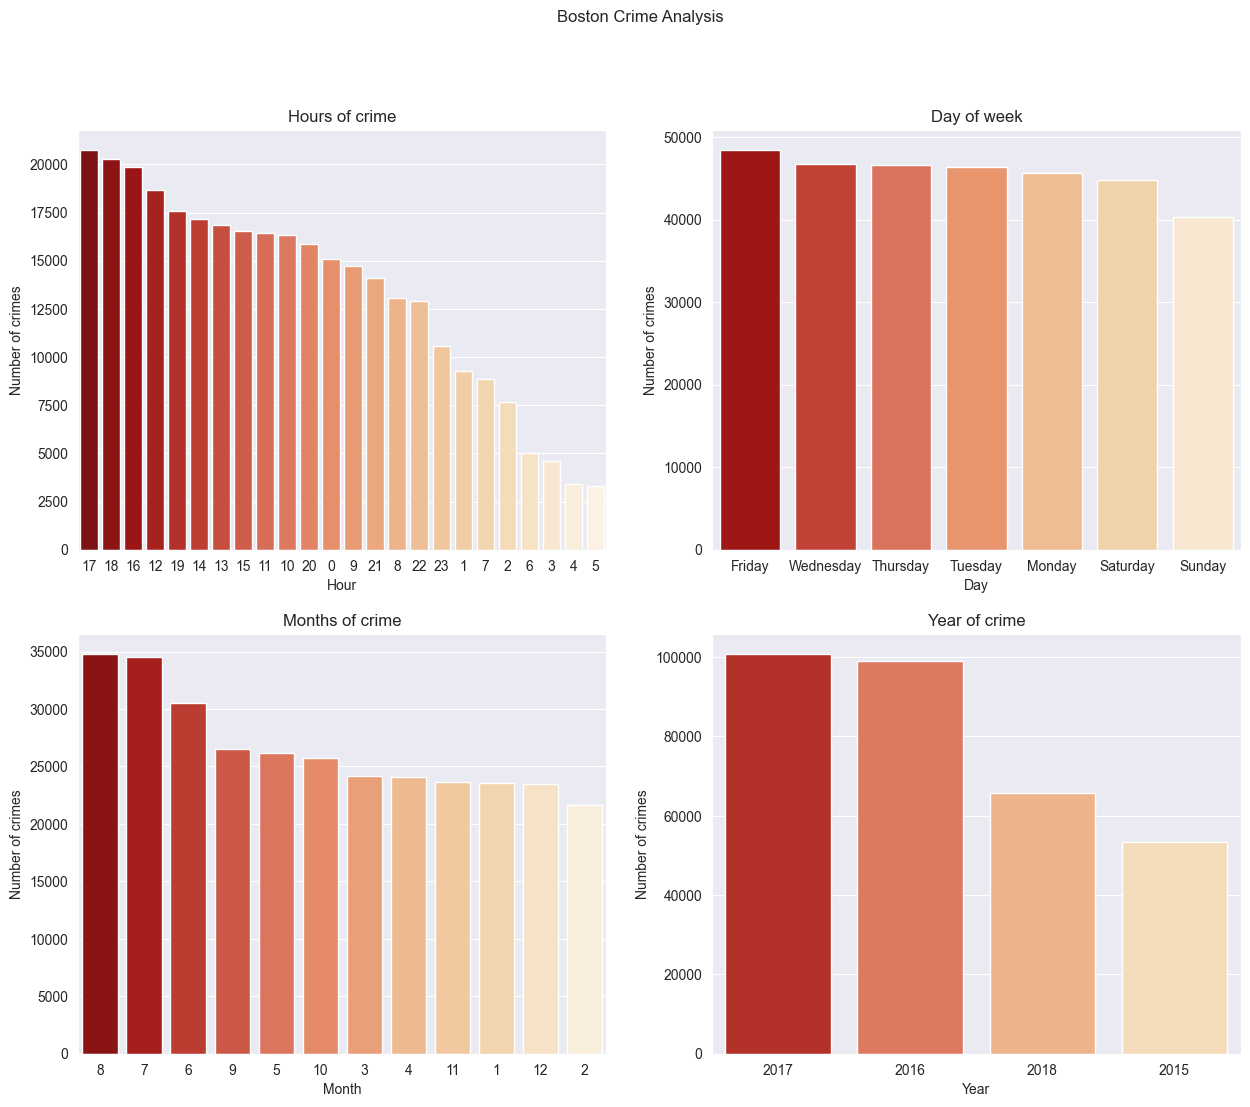

In [186]:
df_hours = df.groupby(['HOUR'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)
df_week = df.groupby(['DAY_OF_WEEK'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)
df_month = df.groupby(['MONTH'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)
df_year = df.groupby(['YEAR'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

sns.barplot(x=df_hours.index, y=df_hours.values, order=df_hours.index, palette="OrRd_r", ax = axs[0,0])
sns.barplot(x=df_week.index, y=df_week.values, order=df_week.index, palette="OrRd_r", ax = axs[0,1])
sns.barplot(x=df_month.index, y=df_month.values, order=df_month.index, palette="OrRd_r", ax = axs[1,0])
sns.barplot(x=df_year.index, y=df_year.values, order=df_year.index, palette="OrRd_r", ax = axs[1,1])

axs[0,0].set_title('Hours of crime')
axs[0,0].set_xlabel('Hour')
axs[0,0].set_ylabel('Number of crimes')

axs[0,1].set_title('Day of week')
axs[0,1].set_xlabel('Day')
axs[0,1].set_ylabel('Number of crimes')

axs[1,0].set_title('Months of crime')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Number of crimes')

axs[1,1].set_title('Year of crime')
axs[1,1].set_xlabel('Year')
axs[1,1].set_ylabel('Number of crimes')

fig.suptitle('Boston Crime Analysis')
plt.show()

##### The above EDA suggests that most crimes in Boston from 2015-2018 took place between 4pm-6pm, with most crimes occurring on Fridays. The data suggests that most crimes in Boston take place in August and July, and that the years 2018 and 2015 saw a reduction in crime. This cannot be assumed to be true, as this Boston crime dataset recorded data from June 2015 to September 2018, meaning we have a full years worth of data for 2017 and 2016 and half a years worth of data for 2018 and 2015.

#### Analysis of crimes

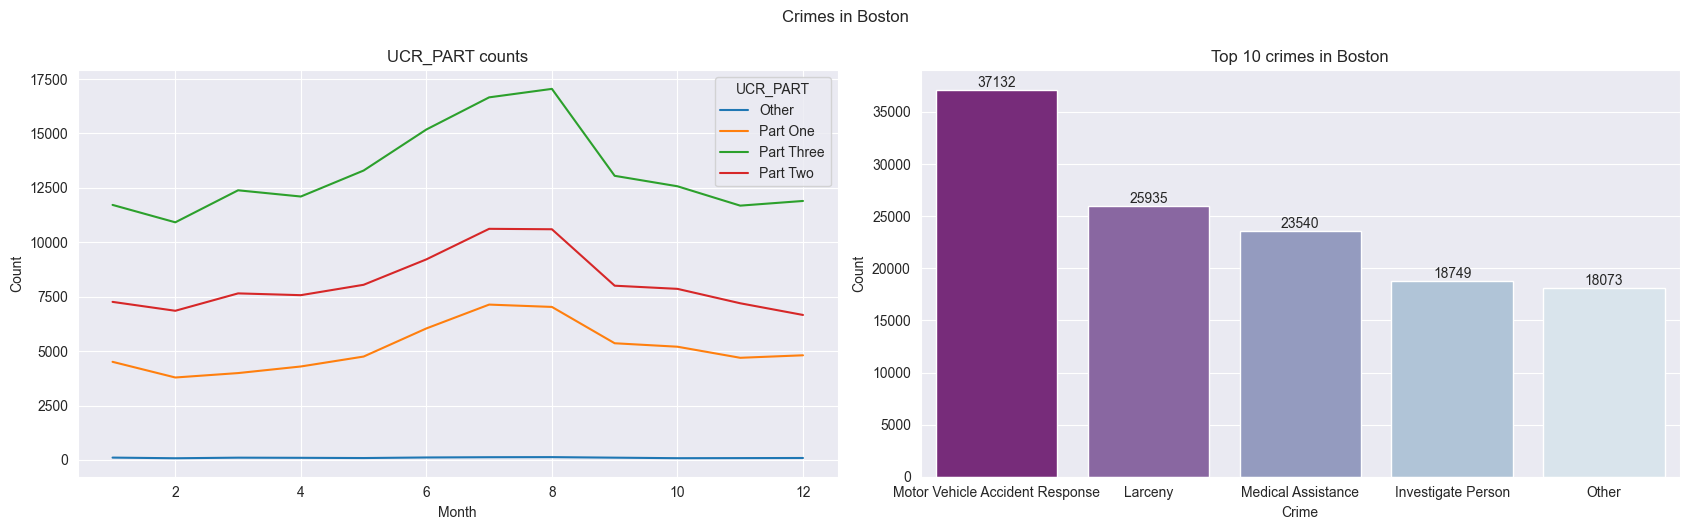

In [247]:
fig, axs = plt.subplots(1, 2, figsize=(17, 5))

df_time = df.groupby(['UCR_PART', df.index.month], observed=True)['INCIDENT_NUMBER'].count().reset_index(name="Count")
df_top10 = df.groupby(['OFFENSE_CODE_GROUP'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)[:5]

ax = sns.lineplot(df_time, x='OCCURRED_ON_DATE', y='Count', hue='UCR_PART', ax=axs[0])
ax1 = sns.barplot(x=df_top10.index, y=df_top10.values, order=df_top10.index, ax=axs[1], palette="BuPu_r")

for i in ax1.containers:
    ax1.bar_label(i,)
    
ax.set_title('UCR_PART counts')
ax1.set_title('Top 10 crimes in Boston')

ax.set_xlabel('Month')
ax.set_ylabel('Count')

ax1.set_xlabel('Crime')
ax1.set_ylabel('Count')

plt.tight_layout()
plt.suptitle("Crimes in Boston", y=1.05)
plt.show()

##### Most crimes taking place in Boston between 2015 and 2018 were classified as Part 3 crimes, which include less severe crimes such as towing and license violations. The top 5 crimes in Boston were: Motor vehicle accident responses, larceny, medical assistance crimes, investigate persons, and other.

#### Crime trends in Boston (2015-2018)

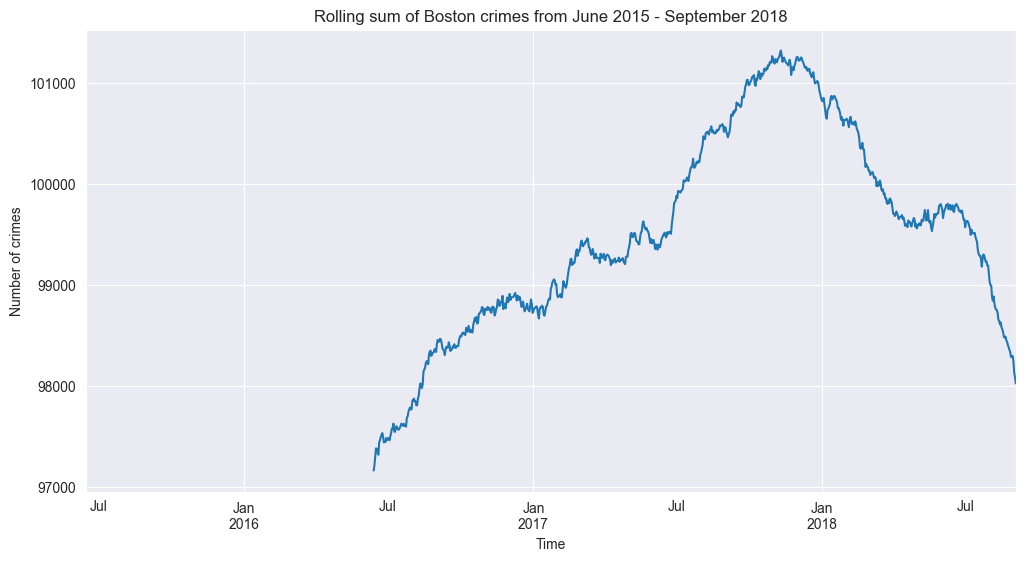

In [188]:
plt.figure(figsize=(12,6))
df.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of Boston crimes from June 2015 - September 2018')
plt.ylabel('Number of crimes')
plt.xlabel('Time')
plt.show()

##### Work in progress...

#### Interactive heatmap of crimes in Boston

In [204]:
#Create heatmap dataframe
step = 0.01
to_bin = lambda x: np.floor(x / step) * step
heatmap = df.copy()
heatmap["Lat"] = to_bin(df["Lat"])
heatmap["Long"] = to_bin(df["Long"])
heatmap = heatmap.groupby(["Lat", "Long", "STREET"]).count()['INCIDENT_NUMBER'].reset_index(name='Count')
heatmap = heatmap[heatmap["STREET"] != "Unknown"]

In [205]:
#Plotting
fig = px.scatter_mapbox(heatmap, lat="Lat", lon="Long", hover_name="STREET", hover_data=["Count"],
                        color="Count", color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'], zoom=11, height=700, size='Count', size_max=40)
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Barplot of top 10 hotspots in Boston

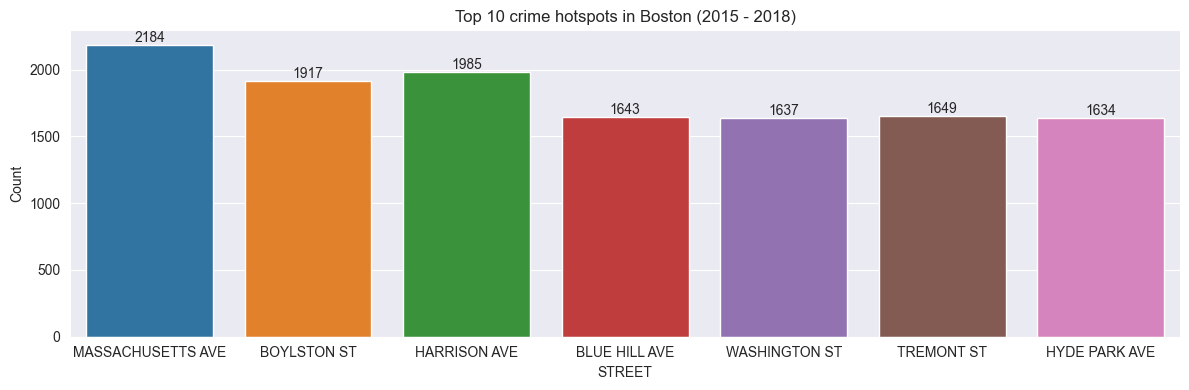

In [206]:
heatmap_top10 = heatmap.sort_values(by="Count", ascending=False)[:10]

plt.figure(figsize=(12,4))
ax = sns.barplot(heatmap_top10, x='STREET', y='Count', errorbar=None)

for i in ax.containers:
    ax.bar_label(i,)
plt.title("Top 10 crime hotspots in Boston (2015 - 2018)")
plt.tight_layout()
plt.show()

##### According to the heatmap above, Massachussets avenue, Bolyston Street, and Harrison Avenue were the most dangerous streets in Boston from 2015 - 2018.

### <u>Machine Learning</u>

#### Import

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import category_encoders as ce

#### Data aquisition and categorical encoding

In [ ]:
null_mask = np.where(~df['Lat'].isnull())[0]

X = df.loc[null_mask, ('Lat', 'Long', 'HOUR', 'DAY_OF_WEEK')]
y = df.iloc[null_mask, 12]

ce.TargetEncoder(return_df=True, cols=['DAY_OF_WEEK']).fit_transform(X, y)


TypeError: Could not convert Part OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreeOtherPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OneOtherPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreeOtherPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OneOtherPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreeOtherPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreeOtherPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreeOtherPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OneOtherPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OneOtherPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OneOtherPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreeOtherPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreeOtherPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OneOtherPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OneOtherPart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreeOtherPart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OneOtherPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoOtherPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreeOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreeOtherPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OneOtherPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OneOtherPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OneOtherPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoOtherPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OneOtherPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OneOtherPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OneOtherPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoOtherPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoOtherPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OneOtherPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OneOtherPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OneOtherPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OneOtherPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OneOtherPart TwoOtherPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoOtherPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OneOtherPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OneOtherPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OneOtherPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OneOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OneOtherPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoOtherPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreeOtherPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OneOtherPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OneOtherPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreeOtherPart OneOtherPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoOtherPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart OneOtherPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoOtherPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OneOtherPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OneOtherPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OneOtherPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreeOtherPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoOtherPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OneOtherPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreeOtherPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoOtherPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OneOtherPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreeOtherPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreeOtherPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreeOtherPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoOtherPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoOtherPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OneOtherPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoOtherPart TwoPart OnePart OnePart TwoPart TwoPart TwoOtherPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OneOtherPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OneOtherPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreeOtherPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoOtherPart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreeOtherPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OneOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoOtherPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OneOtherPart ThreeOtherPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoOtherPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OneOtherPart TwoPart TwoOtherPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoOtherPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoOtherPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OneOtherPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoOtherPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreeOtherPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreeOtherPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OneOtherPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoOtherPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OneOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OneOtherPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OneOtherPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreeOtherPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreeOtherPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OneOtherPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreeOtherPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreeOtherPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OneOtherPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OneOtherPart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreeOtherPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoOtherPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OneOtherPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreeOtherPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OneOtherPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreeOtherOtherPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreeOtherPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreeOtherPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OneOtherPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoOtherPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OneOtherPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreeOtherPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreeOtherPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreeOtherPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreeOtherPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OneOtherPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OneOtherPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoOtherPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoOtherPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreeOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoOtherPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoOtherPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OneOtherPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreeOtherPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoOtherPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreeOtherPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart OnePart ThreePart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreeOtherPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreeOtherPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OneOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OneOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoOtherPart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OneOtherPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreeOtherPart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OneOtherPart ThreePart ThreePart OnePart TwoPart OnePart OneOtherPart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OneOtherPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoOtherPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OneOtherPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoOtherPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoOtherPart OnePart TwoPart TwoPart TwoOtherPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OneOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreeOtherPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OneOtherPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoOtherPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OneOtherPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreeOtherPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoOtherOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart OneOtherPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OneOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OneOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoOtherPart TwoPart TwoPart TwoPart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OneOtherPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OneOtherPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoOtherPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OneOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OneOtherPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreeOtherPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OneOtherPart OnePart OnePart ThreePart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreeOtherPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreeOtherPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreeOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreeOtherPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreeOtherPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OneOtherPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreeOtherPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OneOtherPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoOtherPart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoOtherPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OneOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreeOtherPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreeOtherPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoOtherPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreeOtherPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OneOtherPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OneOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OneOtherPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoOtherPart ThreePart ThreePart ThreeOtherPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoOtherPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OneOtherPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OneOtherPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoOtherPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OneOtherPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OneOtherPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoOtherPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoOtherPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OneOtherPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OneOtherPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OneOtherPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoOtherPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OneOtherPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OneOtherPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoOtherPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoOtherPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OneOtherPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreeOtherPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoOtherPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoOtherPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreeOtherPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreeOtherPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OneOtherPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OneOtherPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OneOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OneOtherPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OneOtherPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreeOtherPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreeOtherPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OneOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreeOtherPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OneOtherPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OneOtherPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoOtherPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OneOtherPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreeOtherPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoOtherPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OneOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreeOtherPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart OneOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OneOtherPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OneOtherPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OneOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoOtherPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OneOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OneOtherPart TwoPart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OneOtherPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoOtherPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoOtherPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoOtherPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoOtherPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreeOtherPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart OnePart TwoOtherPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OneOtherPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreeOtherPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OneOtherPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoOtherPart TwoPart OnePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoOtherPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoOtherPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoOtherPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreeOtherPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OneOtherPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoOtherPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoOtherPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OneOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OneOtherPart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OneOtherPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreeOtherPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OneOtherPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreeOtherPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OneOtherPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OneOtherPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoOtherPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OneOtherPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OneOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OneOtherPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OneOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OneOtherPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OneOtherPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OneOtherPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OneOtherPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OneOtherPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OneOtherPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OneOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreeOtherPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreeOtherPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OneOtherPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreeOtherPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoOtherPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoOtherPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OneOtherPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OneOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OneOtherPart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreeOtherPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreeOtherPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoOtherPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoOtherPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OneOtherPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OneOtherPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OneOtherPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoOtherPart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OneOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OneOtherPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreeOtherPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OneOtherPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OneOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoOtherOtherPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreeOtherPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OneOtherPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OneOtherPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OneOtherPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoOtherPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OneOtherPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OneOtherPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OneOtherPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OneOtherPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreeOtherPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OneOtherPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoOtherPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OneOtherPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreeOtherPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoOtherPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoOtherPart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreeOtherPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OneOtherPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreeOtherPart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreeOtherPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OneOtherPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OneOtherPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OneOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OneOtherPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreeOtherPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreeOtherPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OneOtherPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreeOtherPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OneOtherPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OneOtherPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoOtherPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OneOtherPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreeOtherPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OneOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreeOtherPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoOtherPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreeOtherPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OneOtherPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart OnePart OnePart TwoPart OneOtherPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreeOtherPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreeOtherPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreeOtherPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OneOtherPart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoOtherPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreeOtherPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OneOtherPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OneOtherPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OneOtherPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreeOtherOtherPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OneOtherPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OneOtherPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreeOtherPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoOtherPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OneOtherPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OneOtherPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OneOtherPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreeOtherPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OneOtherPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoOtherPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OneOtherPart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreeOtherPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OneOtherPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreeOtherPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreeOtherPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OneOtherPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoOtherPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OneOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoOtherPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoOtherPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoOtherPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreeOtherPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreeOtherPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoOtherPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart OneOtherPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart TwoPart OneOtherPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoOtherPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OneOtherOtherPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OneOtherPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OneOtherPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreeOtherPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OneOtherPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreeOtherPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreeOtherPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OneOtherPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreeOtherPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart OneOtherPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OneOtherPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreeOtherPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OneOtherPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoOtherPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoOtherPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OneOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OneOtherPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreeOtherPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoOtherPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OneOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OneOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoOtherPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OneOtherPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OneOtherPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoOtherOtherPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreeOtherPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OneOtherPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreeOtherPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreeOtherPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OneOtherPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OneOtherPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreeOtherPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OneOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoOtherPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OneOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreeOtherPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OneOtherPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OneOtherPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OneOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreeOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoOtherPart TwoPart OnePart TwoPart TwoOtherPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreeOtherPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OneOtherPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OneOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreeOtherPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OneOtherPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OneOtherPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OneOtherPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreeOtherPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OneOtherPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoOtherPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OneOtherPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OneOtherPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreeOtherPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreeOtherPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OneOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreeOtherPart ThreePart OnePart ThreePart ThreePart OneOtherPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OneOtherPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoOtherPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OneOtherPart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreeOtherPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OneOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OneOtherPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OneOtherPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart OneOtherPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OneOtherPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoOtherPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OneOtherPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OneOtherPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OneOtherPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OneOtherPart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OneOtherPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OneOtherPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreeOtherPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OneOtherPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoOtherPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OneOtherOtherPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OneOtherPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoOtherPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OneOtherPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreeOtherPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoOtherPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OneOtherPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreeOtherPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreeOtherPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OneOtherPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreeOtherPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoOtherPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OneOtherPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OneOtherPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoOtherPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OneOtherPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoOtherPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OneOtherPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreeOtherPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoOtherPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OneOtherPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OneOtherPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoOtherPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoOtherPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoOtherPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OneOtherPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OneOtherPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoOtherPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OneOtherPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OneOtherPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoOtherPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OneOtherPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoOtherPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoOtherPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreeOtherPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OneOtherPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OneOtherPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OneOtherPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OneOtherPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OneOtherPart TwoOtherPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreeOtherPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreeOtherPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoOtherPart ThreePart TwoPart TwoPart OnePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OneOtherPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OneOtherPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoOtherPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreeOtherPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OneOtherPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OneOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoOtherPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OneOtherPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OneOtherPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoOtherPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OneOtherPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OneOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart TwoOtherPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreeOtherPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OneOtherPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart OneOtherPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart OneOtherPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoOtherPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoOtherPart ThreePart ThreePart OnePart OneOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoOtherPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreeOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoOtherPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreeOtherPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OneOtherPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreeOtherPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OneOtherPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreeOtherPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OneOtherPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OneOtherPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoOtherPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OneOtherPart ThreePart TwoOtherPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreeOtherPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OneOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OneOtherPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OneOtherPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OneOtherPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OneOtherPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OneOtherPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OneOtherPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreeOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OneOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OneOtherPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OneOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OneOtherPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreeOtherPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreeOtherPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoOtherPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreeOtherPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OneOtherPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoOtherPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreeOtherPart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OneOtherPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoOtherPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OneOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreeOtherPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreeOtherPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreeOtherPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OneOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OneOtherPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OneOtherPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreeOtherPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart OneOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoOtherPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OneOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OneOtherPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OneOtherPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OneOtherPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OneOtherPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OneOtherPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OneOtherPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OneOtherPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OneOtherPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OneOtherPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart OneOtherPart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OneOtherPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoOtherPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreeOtherPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OneOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OneOtherPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreeOtherPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoOtherPart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OneOtherPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoOtherPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OneOtherPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OneOtherPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OneOtherPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OneOtherPart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoOtherPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OneOtherPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoOtherPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoOtherPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OneOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OneOtherPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OneOtherPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreeOtherPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreeOtherPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OneOtherPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoOtherPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoOtherPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoOtherPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoOtherPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OneOtherPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OneOtherPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OneOtherPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart OneOtherPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoOtherPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoOtherPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoOtherPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OneOtherPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoOtherPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OneOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoOtherPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoOtherPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreeOtherPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OneOtherPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoOtherPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoOtherPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OneOtherOtherPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OneOtherPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OneOtherPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreeOtherPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoOtherPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoOtherPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OneOtherPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoOtherPart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OneOtherPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoOtherPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OneOtherPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoOtherOtherPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreeOtherPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OneOtherPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoOtherPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoOtherPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoOtherPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OneOtherPart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OneOtherPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoOtherPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoOtherPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OneOtherPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreeOtherPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoOtherPart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OneOtherPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OneOtherPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OneOtherPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoOtherPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoOtherPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoOtherPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreeOtherPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OneOtherPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoOtherPart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreeOtherPart ThreePart ThreeOtherPart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OneOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreeOtherPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoOtherPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoOtherPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoOtherPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OneOtherPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreeOtherPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OneOtherPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreeOtherPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreeOtherPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreeOtherPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreeOtherPart OnePart ThreePart TwoPart TwoPart ThreePart OneOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OneOtherPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoOtherPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoOtherPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoOtherPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OneOtherPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OneOtherPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OneOtherPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OneOtherPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart OneOtherPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OneOtherPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreeOtherPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OneOtherPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreeOtherPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OneOtherPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OneOtherPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart OneOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreeOtherPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoOtherPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreeOtherPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OneOtherPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OneOtherPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OneOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreeOtherPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreeOtherOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OneOtherPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoOtherPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OneOtherPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OneOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreeOtherPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreeOtherPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoOtherPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreeOtherPart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoOtherPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OneOtherPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreeOtherPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoOtherPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OneOtherPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoOtherPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OneOtherPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoOtherPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoOtherPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OneOtherPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoOtherPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoOtherPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OneOtherPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OneOtherPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OneOtherPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoOtherPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OneOtherPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreeOtherPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoOtherPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OneOtherPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreeOtherPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OneOtherPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreeOtherPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreeOtherPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreeOtherPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OneOtherPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OneOtherPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OneOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OneOtherPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreeOtherPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoOtherPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OneOtherPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OneOtherPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoOtherPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OneOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreeOtherPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreeOtherPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreeOtherPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OneOtherPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreeOtherPart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreeOtherPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreeOtherPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OneOtherPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoOtherPart ThreeOtherPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart OneOtherPart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoOtherPart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreeOtherPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoOtherPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OneOtherPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OneOtherPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OneOtherPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OneOtherPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreeOtherPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoOtherPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OneOtherPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoOtherPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OneOtherPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoOtherPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OneOtherPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OneOtherPart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoOtherPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreeOtherPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreeOtherPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OneOtherPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OneOtherPart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OneOtherPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OneOtherPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OneOtherPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoOtherPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoOtherPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OneOtherPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoOtherPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoOtherPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoOtherPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OneOtherPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreeOtherPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreeOtherPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoOtherPart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OneOtherPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart OneOtherPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoOtherPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreeOtherPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OneOtherPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreeOtherPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OneOtherPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoOtherPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreeOtherPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart TwoOtherPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart OnePart TwoPart OneOtherPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreeOtherPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart OnePart TwoPart OnePart OnePart OnePart TwoPart OnePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OneOtherPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreeOtherPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart OnePart OnePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart TwoPart TwoPart TwoPart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart OnePart TwoPart TwoPart OnePart OnePart ThreePart OnePart OnePart OnePart OnePart OneOtherPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoOtherPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart OnePart OnePart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart TwoPart ThreePart ThreePart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreeOtherPart OnePart OnePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart OnePart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart OnePart OnePart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoOtherPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreeOtherPart TwoPart ThreePart OnePart ThreePart ThreePart OnePart OnePart OnePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart TwoPart OnePart OnePart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart OnePart ThreePart OnePart OnePart ThreePart OnePart ThreePart OnePart OnePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart OnePart TwoPart ThreePart OnePart TwoPart TwoPart OnePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart OnePart OnePart TwoPart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart OnePart OnePart OnePart TwoPart TwoPart OnePart ThreePart TwoPart OnePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart TwoPart OnePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart OneOtherPart ThreePart TwoPart OnePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart OnePart TwoPart OnePart ThreePart OnePart OnePart TwoPart TwoPart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart OnePart OnePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart OnePart TwoPart OnePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart OnePart TwoPart OnePart OnePart ThreePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart OnePart TwoPart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart ThreePart OnePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart TwoPart OnePart ThreePart OnePart TwoPart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart OnePart OnePart OnePart OnePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart TwoPart OnePart OnePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart OnePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart OnePart OnePart TwoPart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart ThreePart TwoPart ThreePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoPart TwoPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart ThreeOtherPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoOtherPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart OnePart TwoPart OnePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart ThreePart ThreePart TwoPart OnePart ThreePart ThreePart OnePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart ThreePart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart ThreePart TwoPart TwoPart ThreePart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart OnePart ThreePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart TwoPart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OnePart ThreePart ThreeOtherPart TwoPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart ThreePart OnePart TwoPart ThreePart TwoPart OnePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart TwoPart TwoPart ThreePart OnePart TwoPart TwoPart ThreePart TwoPart OnePart TwoPart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart TwoPart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart ThreePart ThreePart OnePart ThreePart OnePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart TwoPart ThreePart OnePart TwoPart TwoPart TwoPart ThreePart TwoPart OnePart ThreePart TwoPart ThreePart OnePart OnePart ThreePart TwoPart TwoPart ThreePart OnePart OnePart TwoPart ThreePart ThreePart TwoPart TwoPart ThreePart TwoPart OnePart ThreeOtherPart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart OneOtherPart OnePart ThreePart TwoPart ThreePart OnePart ThreePart OnePart OneOtherPart OnePart OnePart ThreePart TwoPart ThreePart TwoPart TwoPart OnePart OnePart ThreePart OnePart ThreePart OnePart OneOtherPart OnePart ThreePart TwoPart ThreePart ThreePart TwoPart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart TwoOtherPart ThreePart ThreePart ThreePart OnePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart ThreePart OnePart ThreePart ThreePart OnePart ThreePart TwoPart TwoPart OnePart ThreePart ThreePart TwoPart TwoPart TwoPart ThreePart ThreePart OnePart ThreePart ThreePart Three to numeric

### Should you drop null Lat and Long rows?

#### Sampling/split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

#### Algorithm training

In [ ]:
clfRandom = RandomForestClassifier(n_jobs=-1)
#clfAda = AdaBoostClassifier()
#clfCat = CatBoostClassifier(verbose=0, n_estimators=100, cat_features=['Police Station'])

#clfCat.fit(X_train, y_train)
clfRandom.fit(X_train, y_train)
#clfAda.fit(X_train, y_train)

ValueError: could not convert string to float: 'Wednesday'

In [ ]:
y_pred = clfRandom.predict(X_test)

array(['Part Two', 'Part Three', 'Part Three', ..., 'Part Three',
       'Part Three', 'Part Three'], dtype=object)

#### Cross-validation

In [ ]:
cv = KFold(n_splits=5)

cv_score_Cat = cross_val_score(clfRandom, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
# cv_score_Random = cross_val_score(clfRandom, X_train, y_train, cv=cv, scoring='f1_weighted')

In [ ]:
print('Random forest: ' + str(round(cv_score_Cat.mean()*100, 2)) + '% ' + str(round(cv_score_Cat.std()*100,2)) + " std, test:", str(round(accuracy_score(y_test, clfRandom.predict(X_test))*100,2)))

Random forest: 46.24% 0.22 std, test: 47.39


### <u>Results</u>

## <center><b>Thanks for reading!</b>